# Global sensitivity Analysis for PULPO

In this notebook we show the workflow for the global sensitivity analysis (GSA) in PULPO.

In [ ]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
import numpy as np
import os
import sys
sys.path.append('../')
from pulpo import pulpo
import scipy.sparse as sparse
from time import time
import stats_arrays
import scipy.stats

In [ ]:
import pyomo.environ as pyo
from pyomo.repn.plugins.baron_writer import *
import pandas as pd
from pathlib import Path
from IPython.display import display
def extract_results(instance, project, database, choices, constraints, demand, process_map, process_map_metadata, itervention_map, itervention_map_metadata, directory, name):
    """
    Args:
        instance: The Pyomo model instance.
        project (str): Name of the project.
        database (str): Name of the database.
        choices (dict): Choices for the model.
        constraints (dict): Constraints applied during optimization.
        demand (dict): Demand data used in optimization.
        process_map (dict): Mapping of process IDs to descriptions.
        process_map_metadata (dict): Metadata to the process_map
        itervention_map (dict): Mapping of intervention IDs to descriptions.
        itervention_map_metadata (dict): Metadata of the itervention_map.
        directory (str): Directory to save the results file.
        name (str): Name of the results file.
    """
    # Recover dictionary values
    # list_of_vars = []
    # for v in instance.component_objects(ctype=pyo.Var, active=True, descend_into=True):
    #     for e in v._data:
    #         v._data[e] = value(v[e])
    #     list_of_vars.append(v)

    result_data = {}
    # inverse_process_map = pd.DataFrame(dict((v, k) for k, v in process_map.items()))
    # inverse_itervention_map = dict((v, k) for k, v in itervention_map.items())
    process_map_df = pd.DataFrame.from_dict(process_map, orient='index', columns=['process_id']).reset_index(names='Process name').set_index('process_id')
    process_map_df['Process metadata'] = process_map_df.index.map(process_map_metadata)
    itervention_map_df = pd.DataFrame.from_dict(itervention_map, orient='index', columns=['intervention_id']).reset_index(names='Intervention name').set_index('intervention_id')
    itervention_map_df['Invervention metadata'] = itervention_map_df.index.map(itervention_map_metadata)
    # Raw results
    for v in instance.component_objects(ctype=pyo.Var, active=True, descend_into=True):
        df = pd.DataFrame.from_dict(v.get_values(), orient='index', columns=['Value']).sort_values('Value', ascending=False)
        match v.name:
            case 'inv_flows' | 'inv_vector':
                df = df.join(itervention_map_df, how='left').reset_index(names='ID')          
            case 'scaling_vector':
                df = df.join(process_map_df, how='left').reset_index(names='ID')
            case 'impacts' | 'slack' | 'impacts_calculated':
                df = df.reset_index(names='Key')
        result_data[v.name] = df

    # Normalize database to a list if it is a string
    if isinstance(database, str):
        database = [database]

    # Store the metadata
    result_data["project and db"] = pd.DataFrame([f"{project}__{db}" for db in database])

    # ATTN: BHL: This needs to be rewritten, it is very convoluted and can be more clear
    choices_data = {}
    for choice, alternatives in choices.items():
        temp_dict = []
        for i_alt, alt in enumerate(alternatives):
            temp_dict.append((alt, i_alt, instance.scaling_vector.get_values()[process_map[alt.key]]))
        choices_data[(choice, 'Process')] = {f'Process {i}': process_map_metadata[process_map[alt.key]] for alt, i, _ in temp_dict}
        choices_data[(choice, 'Capacity')] = {f'Process {i}': alternatives[alt] for alt, i, val in temp_dict}
        choices_data[(choice, 'Value')] = {f'Process {i}': x for _, i, x in temp_dict}
    result_data["choices"] = pd.DataFrame(choices_data)

    result_data["demand"] = pd.DataFrame({"demand":{
        process_map_metadata[process_map[key]] if key in process_map else key: demand[key]
        for key in demand
    }})
    result_data["constraints"] = pd.DataFrame({"Demand": {process_map_metadata[process_map[key]]: constraints[key] for key in constraints}})

    return result_data

def save_results(result_data, file_name):
    with pd.ExcelWriter(f"{directory}/results/{file_name}.xlsx") as writer:
        for sheet_name, dataframe in result_data.items():
            dataframe.to_excel(writer, sheet_name=sheet_name)

## 1. Defining the case

The case for which the sensitivity analysis will be performed for is on a solution of the LP:

$$
    \begin{align}
        & \underset{s, slack}{\text{min}}  && z_h \\
        & \text{s.t.}   && \sum_{j}(a_{i,j}\cdot s_j) = f_i && \forall i \\
        &               && s_j^{low} \leq s_j \leq s_j^{high} && \forall j \\
        &               && z_h = \sum_e \sum_j (q_{h,e}\cdot b_{e,j} \cdot s_j) && \forall h \\
    \end{align}
$$


### 1.1. Rice husk problem


#### 1.1.1. Loading the the data

If the rise husk database has not been installed yet

In [ ]:
# pulpo.install_rice_husk_db()

Set the parameters for the rise husk example to instancialize PULPO

In [ ]:
project = "rice_husk_example" 
database = "rice_husk_example_db"
method = "('my project', 'climate change')"
notebook_dir = os.path.dirname(os.getcwd())
directory = os.path.join(notebook_dir, 'develop_tests/data')

Create a **PulpoOptimizer** instance. This class is used to interact with the LCI database and solve the optimization problem. It is specified by the project, database, method and directory.

In [ ]:
pulpo_worker = pulpo.PulpoOptimizer(project, database, method, directory)

Import LCI data. After initializing the PulpoOptimizer instance, the LCI data is imported from the database.

In [ ]:
pulpo_worker.get_lci_data()

#### 1.1.2. Defining the optimizaiton problem

Specify the **functional unit**. In this case, the functional unit is 1 Mt of processed rice. PULPO implements a search function (```retrieve_processes```) to find the processes that match the specified reference products (alternatively: keys, process name, region).

In [ ]:
rice_factory = pulpo_worker.retrieve_processes(reference_products='Processed rice (in Mt)')

demand = {rice_factory[0]: 1}

Specify the **choices**. Here, the choices are regional 🌐 choices for rise husk collections, and technological ⛏ choices for boiler type selection.

The auxiliar choices are needed to resolve the issue that rice, when not used in the boiler must be burned instead. 

(*At this point, just accept. If you are curious about how this multi-functionality is technically adressed, refer to the paper, or reach out.*)

In [ ]:
## Rise husk collection
rice_husk_processes = ["Rice husk collection 1",
              "Rice husk collection 2",
              "Rice husk collection 3",
              "Rice husk collection 4",
              "Rice husk collection 5",]
rice_husk_collections = pulpo_worker.retrieve_processes(processes=rice_husk_processes)

In [ ]:
## Boilers
boiler_processes = ["Natural gas boiler",
                     "Wood pellet boiler",
                     "Rice husk boiler"]
boilers = pulpo_worker.retrieve_processes(processes=boiler_processes)

In [ ]:
## Auxiliar (Ignore for now!)
auxiliar_processes = ["Rice husk market",
                       "Burning of rice husk"]
auxiliar = pulpo_worker.retrieve_processes(processes=auxiliar_processes)

In [ ]:
## Combine to create the choices dictionary
## For each kind of choice, assign a 'label' (e.g. 'boilers')
## To each possible choice, assign a process capacity. In the 'unconstrained' case, set this value very high (e.g. 1e10, but depends on the scale of the functional unit)
choices = {'Rice Husk (Mt)': {rice_husk_collections[0]: 0.03,
                              rice_husk_collections[1]: 0.03,
                              rice_husk_collections[2]: 0.03,
                              rice_husk_collections[3]: 0.03,
                              rice_husk_collections[4]: 0.03},
           'Thermal Energy (TWh)': {boilers[0]: 1e10,
                                    boilers[1]: 1e10,
                                    boilers[2]: 1e10},
           'Auxiliar': {auxiliar[0]: 1e10,
                        auxiliar[1]: 1e10}}

#### 1.1.3. Instantiat and solve the optimization model

In [ ]:
pulpo_worker.instantiate(choices=choices, demand=demand)

In [ ]:
results = pulpo_worker.solve()

#### 1.1.4. Save and summarize the results

In [ ]:
result_data = extract_results(pulpo_worker.instance, pulpo_worker.project, pulpo_worker.database, choices, {}, demand,
                            pulpo_worker.lci_data['process_map'], pulpo_worker.lci_data['process_map_metadata'],
                            pulpo_worker.lci_data['intervention_map'], pulpo_worker.lci_data['intervention_map_metadata'],
                            pulpo_worker.directory, "")
result_data
# pulpo_worker.summarize_results(choices=choices, demand=demand, zeroes=True)

In [ ]:
save_results(result_data, "new_test_extract_data")

### 1.2. Defining the electricity showcase problem

#### 1.2.1. Import the data

In [ ]:
# Your brightway2 project, database and targeted impact category
project = "pulpo"
database = "cutoff38"
methods = {"('IPCC 2013', 'climate change', 'GWP 100a')": 1,
           "('ReCiPe Endpoint (E,A)', 'resources', 'total')": 0,
           "('ReCiPe Endpoint (E,A)', 'human health', 'total')": 0,
           "('ReCiPe Endpoint (E,A)', 'ecosystem quality', 'total')": 0,
           "('ReCiPe Midpoint (E) V1.13', 'ionising radiation', 'IRP_HE')": 0}

# Substitute with your working directory of choice
notebook_dir = os.path.dirname(os.getcwd())
directory = os.path.join(notebook_dir, 'data')

In [ ]:
# Create a PULPO object
pulpo_worker = pulpo.PulpoOptimizer(project, database, methods, directory)

In [ ]:
# Retrieve LCI data
pulpo_worker.get_lci_data()

#### 1.2.2. Define the optimization problem

In [ ]:
# Retrieve the electricity market
activities = ["market for electricity, high voltage"]
reference_products = ["electricity, high voltage"]
locations = ["DE"]
electricity_market = pulpo_worker.retrieve_activities(activities=activities,
                                                      reference_products=reference_products,
                                                      locations=locations)

In [ ]:
# Specify the functional unit as demand dictionary
demand = {electricity_market[0]: 1.28819e+11}

In [ ]:
# Retrieve the choices
activities = ["electricity production, lignite", 
             "electricity production, hard coal",
             "electricity production, nuclear, pressure water reactor",
             "electricity production, wind, 1-3MW turbine, onshore"]
reference_products = ["electricity, high voltage"]
locations = ["DE"]

electricity_activities = pulpo_worker.retrieve_activities(activities=activities,
                                                          reference_products=reference_products,
                                                          locations=locations)

In [ ]:
# Specify the choices dictionary
choices  = {'electricity': {electricity_activities[0]: 1e16,
                            electricity_activities[1]: 1e16,
                            electricity_activities[2]: 1e16,
                            electricity_activities[3]: 1e16}}

#### 1.2.3. Initialize and solve the optimization problem

In [210]:
# Instantiate and solve the problem (here with HiGHS)
instance = pulpo_worker.instantiate(choices=choices, demand=demand)

Creating Instance
Instance created


In [211]:
# import pyomo.environ as pyon
# import os
# os.environ['NEOS_EMAIL'] = 'b.j.p.m.haussling.lowgren@cml.leidenuniv.nl'
# solver_manager = pyon.SolverManagerFactory('neos')

In [212]:
# from contextlib import redirect_stdout
# with open(r'pyomo_optimization_model_electricity_showcase.txt', 'w') as f:
#     with redirect_stdout(f):
#         pulpo_worker.instance.pprint()

In [213]:
# results = solver_manager.solve(pulpo_worker.instance, opt='cplex', tee=True)

In [214]:
pulpo_worker.solve()

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Cols:       39128 lower bounds exceeding       -1e+20 are treated as -Infinity
Cols:       39128 upper bounds exceeding        1e+20 are treated as +Infinity
Rows:       19561 lower bounds exceeding       -1e+20 are treated as -Infinity
Rows:       19562 upper bounds exceeding        1e+20 are treated as +Infinity


#### 1.2.4. Summarize and save the results

In [215]:
result_data = extract_results(pulpo_worker.instance, pulpo_worker.project, pulpo_worker.database, choices, {}, demand,
                            pulpo_worker.lci_data['process_map'], pulpo_worker.lci_data['process_map_metadata'],
                            pulpo_worker.lci_data['intervention_map'], pulpo_worker.lci_data['intervention_map_metadata'],
                            pulpo_worker.directory, "")
result_data

{'impacts':                                            Key         Value
 0  ('IPCC 2013', 'climate change', 'GWP 100a')  1.599836e+10,
 'scaling_vector':           ID         Value                                  Process name  \
 0      14779  2.770870e+11  (cutoff38, 0cbb759cc5686df90185c3fbc7b8262b)   
 1        637  2.770870e+11  (cutoff38, 2040efe62886e6f108756a2b60d663a1)   
 2       7239  1.346918e+11  (cutoff38, 962727b9a36bcaa186f222b29b57f6a3)   
 3       6498  8.350729e+10  (cutoff38, 0058af82cdce10e512dc11f68a00a8eb)   
 4      15234  2.837404e+10  (cutoff38, e4b81a6357b79091e76dc2836ef1fc52)   
 ...      ...           ...                                           ...   
 19560   2028 -6.993395e+05  (cutoff38, 8e8cdd680e8d61271f4fa838a24bed1a)   
 19561  13440 -7.185991e+05  (cutoff38, 0bb079bf4e6142ad612b2b08e043f4ba)   
 19562   5551 -8.139695e+05  (cutoff38, 9b0bb421368f11d8ad6fd72066eca3d0)   
 19563  14649 -1.385271e+07  (cutoff38, 18955e2d43eeb55c9ae99705a5170cca)   

In [209]:
result_data['choices']

electricity                \
                                                     Process      Capacity   
Process 0  electricity production, hard coal | electricit...  1.000000e+16   
Process 1  electricity production, nuclear, pressure wate...  1.000000e+16   
Process 2  electricity production, wind, 1-3MW turbine, o...  1.000000e+16   
Process 3  electricity production, lignite | electricity,...  1.000000e+16   

                         
                  Value  
Process 0 -0.000000e+00  
Process 1  8.350729e+10  
Process 2 -0.000000e+00  
Process 3 -0.000000e+00

## 2. Preparing the data for the sensitivity analysis

**Reformulating the problem for the sensitivity analysis**

We only consider uncertainty in the $B$ and $Q$ parameter matrizes. The scaling vector is given by the optimal solution.

We will look at the environmental impact objective:

$$
    e(Q, B) =  Q \cdot B \cdot s
$$

### 2.0. Preparing the sampling of the parameter space

In [ ]:
# Loop place holer, will loop over all the following code
# method_index = 1
# for i_method, ((mat_method, mat_characterization_matrix), (param_mat, param_characterization_params)) in enumerate(zip(pulpo_worker.lci_data["matrices"].items(), pulpo_worker.lci_data["characterization_params"].items())):
#     if i_method == method_index:
#         method = mat_method
#         characterization_matrix = mat_characterization_matrix
#         characterization_params = param_characterization_params
#         print(method)
method = result_data['impacts']['Key'][0]
characterization_matrix = pulpo_worker.lci_data["matrices"][method]
characterization_params = pulpo_worker.lci_data["characterization_params"][method]
method

In [ ]:
# put the scaling vector returned from the optimization into the same order as the process map
scaling_vector_series = result_data["scaling_vector"]["Value"].reindex(pulpo_worker.lci_data['process_map'].values())


### 2.1. Compute the LCI and LCIA results per flow

In [ ]:
# LCI calculatiom
count = len(pulpo_worker.lci_data["process_map"])
inventory = pulpo_worker.lci_data['intervention_matrix'] * \
sparse.spdiags([scaling_vector_series.values], [0], count, count)

In [ ]:
# LCIA calculation
characterized_inventory = \
characterization_matrix * inventory
lca_score = characterized_inventory.sum()
print('The total impact is: {:e}'.format(lca_score))

### 2.2. Filtering out the Biosphereflows $B_{i,j}$ that have a neglectable impact

In [ ]:
#ATTN: Add a simple optimization loop to find the cutoff which results in an absolute change of around 1%
cutoff = 0.0005

In [ ]:
# Filters the biosphere flows
start = time()
print('Characterized inventory:', characterized_inventory.shape, characterized_inventory.nnz)
finv = characterized_inventory.multiply(abs(inventory) > abs(lca_score*cutoff))
print('Filtered characterized inventory:', finv.shape, finv.nnz)
characterized_inventory_indices = list(zip(*finv.nonzero()))
explained_fraction = finv.sum() / lca_score
print('Explained fraction of LCA score:', explained_fraction)
print('BIOSPHERE {} filtering resulted in {} of {} exchanges ({}% of total impact) and took {} seconds.'.format(
    characterized_inventory.shape,
    finv.nnz,
    characterized_inventory.nnz,
    np.round(explained_fraction * 100, 2),
    np.round(time() - start, 2),
))


### 2.3. Filter out the characterization factors not used for the biosphere

In [ ]:
# Filter characterization matrix
characterization_matrix_ids = characterization_matrix.diagonal().nonzero()[0]
reduced_characterization_matrix_ids = []
for (bio_i, ex_i) in characterized_inventory_indices:
    if bio_i in characterization_matrix_ids and bio_i not in reduced_characterization_matrix_ids:
        reduced_characterization_matrix_ids.append(bio_i)

## 3. Getting the standard deviation of the parameter values

### 3.1. Get the paramteric uncertainty of the biosphere parameters found in the database

In [ ]:
intervention_metadata_df = pd.DataFrame(pulpo_worker.lci_data['intervention_params'])
intervention_metadata_df = intervention_metadata_df.set_index(["row", "col"])

In [ ]:
intervention_flows_defined_uncertainty = {}
intervention_flows_undefined_uncertainty = []
for characterized_inventory_index in characterized_inventory_indices:
    intervention_metadata = intervention_metadata_df.loc[characterized_inventory_index]
    if intervention_metadata['uncertainty_type']>0: # if the uncertainty type is larger than 0, meaining there is an uncertainty defined
        intervention_flows_defined_uncertainty[characterized_inventory_index] = intervention_metadata.to_dict()
    else: # if no uncertainty data is available
        intervention_flows_undefined_uncertainty.append(characterized_inventory_index)
print("Intervention flows with uncertainty information: {} \nIntervention flows without uncertainty information: {}".format(len(intervention_flows_defined_uncertainty), len(intervention_flows_undefined_uncertainty)))



### 3.2. Get the paramteric uncertainty of the characterizaiton factors found in the database

In [ ]:
characterization_metadata_df = pd.DataFrame(characterization_params).set_index('row')

In [ ]:
characterization_factors_defined_uncertainty = {}
characterization_factors_undefined_uncertainty = []
for characterization_matrix_index in reduced_characterization_matrix_ids:
    characterization_metadata = characterization_metadata_df.loc[characterization_matrix_index]
    if characterization_metadata['uncertainty_type']>0: # if the uncertainty type is larger than 0, meaining there is an uncertainty defined
        characterization_factors_defined_uncertainty[characterization_matrix_index] = characterization_metadata.to_dict()
    else: # if no uncertainty data is available
        characterization_factors_undefined_uncertainty.append(characterization_matrix_index)
print("Characterization factors with uncertainty information: {} \nCharacterization factors without uncertainty information: {}".format(len(characterization_factors_defined_uncertainty), len(characterization_factors_undefined_uncertainty)))


### 3.3. Set the uncertainty concept for the undefined uncertainty parameters

https://stats-arrays.readthedocs.io/en/latest/

![alt text](stats_arrays_table.JPG "Title")

#### 3.3.1. Set the uncertainty concept for the intervention flows and compute the bounds

Compute the bounds of the uncertain intervention flows using `stats.arrays`

In [ ]:
if not intervention_flows_defined_uncertainty:
    raise Exception('There are no intervention flows with defined uncertainty, we must implement another uncertainty approach in that case')
if len(intervention_flows_defined_uncertainty) < len(intervention_flows_undefined_uncertainty):
    raise Exception('There are more intervention flows with no defined uncertainty than defined uncertainty, this is a trivial measure set to warn the user if the averages bounds approach is useful')
intervention_flow_defined_uncertainty_bounds = {}
for intervention_flow_index, intervention_flow_uncertainty_dict in intervention_flows_defined_uncertainty.items():
    intervention_flow_uncertainty_array = stats_arrays.UncertaintyBase.from_dicts(intervention_flow_uncertainty_dict)
    uncertainty_choice = stats_arrays.uncertainty_choices[intervention_flow_uncertainty_dict['uncertainty_type']]
    intervention_flow_statistics = uncertainty_choice.statistics(intervention_flow_uncertainty_array)
    intervention_flow_defined_uncertainty_bounds[intervention_flow_index] = intervention_flow_statistics

In [ ]:
intervention_flow_defined_uncertainty_bounds_df = pd.DataFrame(intervention_flow_defined_uncertainty_bounds).T

Test if the bounds are valid upperbound > lowerbound

In [ ]:
if ((intervention_flow_defined_uncertainty_bounds_df['upper'] - intervention_flow_defined_uncertainty_bounds_df['lower']) <= 0).any():
    raise Exception('There is one bound where the lower bound which is equal or larger than the upper bound')

Compute the statistics of the lower and upper bounds returned from the parameter distributions to decide which metric to use for the flows which do not have uncertainty information

In [ ]:
lower_spread = intervention_flow_defined_uncertainty_bounds_df['lower'] / intervention_flow_defined_uncertainty_bounds_df['mean']
upper_spread = intervention_flow_defined_uncertainty_bounds_df['upper'] / intervention_flow_defined_uncertainty_bounds_df['mean']
ax = lower_spread.hist(bins=30, label='lower spread')
upper_spread.hist(bins=30, label='upper spread', ax=ax)
ax.legend()
print('upper spread statistics')
print(upper_spread.describe())
print('\nlower spread statistics')
print(lower_spread.describe())

based on the statistics below, I decided to use the mean of the means fraction of the upper and lower bound

In [ ]:
intervention_flow_upper_spread_scaling_factor = upper_spread.mean()
intervention_flow_lower_spread_scaling_factor = lower_spread.mean()
print('The upper spread scaling factor for intervention flows is: {}\nThe lower spread scaling factor for intervention flows is: {}'.format(intervention_flow_upper_spread_scaling_factor, intervention_flow_lower_spread_scaling_factor))

Based on this the bounds of the intervention flows without uncertainty is computed

In [ ]:
intervention_flow_undefined_uncertainty_bounds = {}
for intervention_flow_index in intervention_flows_undefined_uncertainty:
    intervention_flow_uncertainty_dict = {
        'median': intervention_metadata_df.loc[intervention_flow_index].amount,
        'upper': intervention_flow_upper_spread_scaling_factor * intervention_metadata_df.loc[intervention_flow_index].amount,
        'lower': intervention_flow_lower_spread_scaling_factor * intervention_metadata_df.loc[intervention_flow_index].amount
    }
    intervention_flow_undefined_uncertainty_bounds[intervention_flow_index] = intervention_flow_uncertainty_dict

Test if the bounds are valid: upper-bound > lower-bound

In [ ]:
intervention_flow_undefined_uncertainty_bounds_df = pd.DataFrame(intervention_flow_undefined_uncertainty_bounds).T
if ((intervention_flow_undefined_uncertainty_bounds_df['upper'] - intervention_flow_undefined_uncertainty_bounds_df['lower']) <= 0).any():
    raise Exception('There is one bound where the lower bound which is equal or larger than the upper bound')

#### 3.3.2. Set the uncertainty concept for the characterization factors and compute the bounds

The characterization factors uncertainty depend strongly on the method chosen and also on the time horizon etc.

**For now we are choosing an arbitrary bound scaling value of 0.3**

In [ ]:
characterization_factor_upper_scaling_factor = 1.15
characterization_factor_lower_scaling_factor = 0.85

Compute the bounds based on the scaling factor

In [ ]:
if len(characterization_factors_defined_uncertainty) > 0:
    raise Exception('There are characterization factor uncertainty in the data, use these! (code not implemented yet, but analogueous to intervention flows)')

characterization_factors_undefined_uncertainty_bounds = {}
for characterization_factor_index in characterization_factors_undefined_uncertainty:
    characterization_factor_uncertainty_dict = {
        'median': characterization_metadata_df.loc[characterization_factor_index].amount,
        'lower': characterization_factor_lower_scaling_factor * characterization_metadata_df.loc[characterization_factor_index].amount,
        'upper': characterization_factor_upper_scaling_factor * characterization_metadata_df.loc[characterization_factor_index].amount
    }
    characterization_factors_undefined_uncertainty_bounds[characterization_factor_index] = characterization_factor_uncertainty_dict

Test if the bounds are valid: upper-bound > lower-bound

In [ ]:
characterization_factors_undefined_uncertainty_bounds_df = pd.DataFrame(characterization_factors_undefined_uncertainty_bounds).T
if ((characterization_factors_undefined_uncertainty_bounds_df['upper'] - characterization_factors_undefined_uncertainty_bounds_df['lower']) <= 0).any():
    raise Exception('There is one bound where the lower bound which is equal or larger than the upper bound')

## 4. Define the global sensitivity problem
### 4.1. Define the bound/interval of the parameters
Defining the bound as plus minus the standard deviation, $\sigma^2$, of the nominal value, $\mu$, for each parameter, $p$:

$[\mu_p - \sigma^2_p; \mu_p + \sigma^2_p]$

### 4.2. Defining the sampling problems

In [ ]:
all_bounds = intervention_flow_defined_uncertainty_bounds | intervention_flow_undefined_uncertainty_bounds | characterization_factors_undefined_uncertainty_bounds
all_bounds_indx_dict = {
    "intervention_flows_end": len(intervention_flow_defined_uncertainty_bounds | intervention_flow_undefined_uncertainty_bounds),
    "characterization_factors_start":len(intervention_flow_defined_uncertainty_bounds | intervention_flow_undefined_uncertainty_bounds),
}

In [ ]:
problem = {
    'num_vars': len(all_bounds),
    'names': list(all_bounds.keys()),
    'bounds': [[bound['lower'], bound['upper']]for bound in all_bounds.values()]
}

### 4.3. Define the sampling method

Select the sampling method, any sampling method from SALib can be chosen, but for most sensitivity analysis there is a sampling method best suited or even neccessary, in this case we use `saltelli` sampling because it is best compatible with Sobol' sequence.

In [ ]:
from SALib.sample import sobol as sample_method

Choose the amount of samples 

In [ ]:
N = 2**7
N

### 4.4. Define the sensitivity analysis method

Select the sensitivity analysis method, remember it is mostly coupled to the sampling method, any sensitivity method from the SALib can be chosen. For this case study we chose Sobol' method

In [ ]:
from SALib.analyze import sobol as SA_method

## 5. Perform the sensitivity analysis

$$
    e(Q, B) =  Q \cdot B \cdot s
$$

### 5.1. Sampling the $Q$ and $B$ arrays

In [ ]:
sample_data = sample_method.sample(problem, N)

### 5.2. Solving for $Q \cdot B \cdot s$

extract matrizes from sample data

In [ ]:
sample_intervention_flows = pd.DataFrame(
    sample_data[:,:all_bounds_indx_dict['intervention_flows_end']], 
    columns=pd.MultiIndex.from_tuples(problem['names'][:all_bounds_indx_dict['intervention_flows_end']])
    )
sample_characterization_factors = pd.DataFrame(
    sample_data[:,all_bounds_indx_dict['characterization_factors_start']:], 
    columns=problem['names'][all_bounds_indx_dict['characterization_factors_start']:]
    )

Compute the environmental costs $Q \cdot B$ by reindexing the chracterization factors sample based on the intervention flow sample, so we can do dot product between for each characterization factors corresponding to the intervnetnion flow

In [ ]:
sample_characterization_factors_expanded = sample_characterization_factors.reindex(sample_intervention_flows.columns, axis=1, level=0)
sample_environmental_costs = sample_characterization_factors_expanded * sample_intervention_flows

Compute the environmental impact using a dot product of the reindex scaling vector

In [ ]:
scaling_vector_expanded = scaling_vector_series.reindex(sample_intervention_flows.columns, level=1)

In [ ]:
sample_characterized_inventories = sample_environmental_costs * scaling_vector_expanded

### 5.3. Calculate the total output variance

Since we have multiple impact categories in the sampled data and we can only perform the sensitivity analysis per category, we have to specify the category from the data

In [ ]:
sample_impacts = sample_characterized_inventories.sum(axis=1)

Test if the bounds are valid: upper-bound > lower-bound

In [ ]:
intervention_flow_undefined_uncertainty_bounds_df = pd.DataFrame(intervention_flow_undefined_uncertainty_bounds).T
if ((intervention_flow_undefined_uncertainty_bounds_df['upper'] - intervention_flow_undefined_uncertainty_bounds_df['lower']) <= 0).any():
    raise Exception('There is one bound where the lower bound which is equal or larger than the upper bound')

In [ ]:
print(f'The statistics of the the sample impacts: {method}')
print(sample_impacts.describe())
print('The deterministic impact is {}'.format('\n'.join(['{} : {:e}'.format(values[0], values[1]) for values in result_data['impacts'].values])))

#### 5.3.1.  Show the z-value and the distribution of the output

In [ ]:
sample_impacts.plot.hist(bins=10)
sample_impacts.shape

The z-value of the total environmental impact

In [ ]:
sample_impacts.std()/sample_impacts.mean()

### 5.4. Calculate Sobol index

In [ ]:
Si_impacts = SA_method.analyze(problem, sample_impacts.values)

In [ ]:
# total_Si_impacts, first_Si_impacts, second_Si_impacts = Si_impacts.to_df()
total_Si_impacts = pd.DataFrame([Si_impacts['ST'].T, Si_impacts['ST_conf'].T], index=['ST', 'ST_conf'], columns=problem['names']).T

#### 5.4.1. Calculate total explained variance

In [ ]:
print("The total explained variance is \n{:.4}%".format(total_Si_impacts["ST"].sum()*100))

### 5.5. Select the uncertain parameters with the largest explained variane

Select the uncertain parameters using a cut-off value 

In [ ]:
cutoff_total_explained_variance = 0.01

In [ ]:
reduced_total_Si_impacts = total_Si_impacts.sort_values("ST", ascending=False)[total_Si_impacts["ST"]>cutoff_total_explained_variance]
print('{} uncertain parameters remain after using a cutoff value of {}% for the total variance.'.format(reduced_total_Si_impacts.shape[0], cutoff_total_explained_variance*100))

### 5.6. Plot the contribution to variance

Generate the data and the names for the contribution plot

In [ ]:
def set_size(width, height, fraction=1):
    """ Set aesthetic figure dimensions to avoid scaling in latex.
 
    Parameters
    ----------
    width: float
            Width in pts
    fraction: float
            Fraction of the width which you wish the figure to occupy
 
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure
    fig_width_pt = width * fraction    
 
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27
 
    # Golden ratio to set aesthetic figure height
    golden_ratio = (5**.5 - 1) / 2
 
    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    if height: #if height is specified
        fig_height_pt = height * fraction
        fig_height_in = fig_height_pt * inches_per_pt
    else:
        fig_height_in = fig_width_in * golden_ratio
 
    fig_dim = (fig_width_in, fig_height_in)
 
    return fig_dim

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import textwrap

def plot_SA_barplot(data:pd.DataFrame, metadata:pd.DataFrame, colormap:pd.Series=pd.Series([]), bbox_to_anchor_lower:float = -0.6, bbox_to_anchor_center:float=0.5):
    """
        Barplot of the contributional variance of the parameters in an objective

        args:
            data:       dataframe with columns: "ST" and "ST_conf"
            metadata:   metadataframe with "bar_names" column and same indices as data
            colormap:   Series with color codes to each data index     `colormap = pd.Series(mpl.cm.tab20.colors[:data.shape[0]], index=data.index)`
            bbox_to_anchor_lower: negative float, scaled how much the legend is under the plot
    """
    # width = 180
    # height = 180
    width = 4.77*72.4#600
    height = None
    _, ax = plt.subplots(1, 1, figsize=set_size(width,height))

    # Data
    data = data.sort_values(["ST"], ascending=False)
    heights = data["ST"].values * 100
    yerrs = data["ST_conf"].values * 100
    bars = [textwrap.fill(string, 50) for string in metadata["bar_names"].reindex(data.index)]
    y_pos = range(len(bars))
    
    for height, y_po, yerr, indx in zip(heights, y_pos, yerrs, data.index):
        ax.bar(y_po, height, yerr=yerr, capsize=5, ecolor="gray", color=colormap[indx], alpha=0.9)
    ax.set_xticks([])
    if (data["ST"]<=1).all() and (data["ST"]>=0).all():
        ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
        ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
        # For the minor ticks, use no labels; default NullFormatter.
        ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
    ax.legend(bars, loc='lower center', bbox_to_anchor=(bbox_to_anchor_center, bbox_to_anchor_lower), borderpad=1)
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='gray', linestyle='dotted')
    return ax

In [ ]:
metadata_dict = {}
for (intervention_index, process_index) in total_Si_impacts.index[:all_bounds_indx_dict['intervention_flows_end']]:
    metadata_dict[(intervention_index, process_index)] = '{} --- {}'.format(pulpo_worker.lci_data['process_map_metadata'][process_index], pulpo_worker.lci_data['intervention_map_metadata'][intervention_index])
for intervention_index in total_Si_impacts.index[all_bounds_indx_dict['characterization_factors_start']:]:
    metadata_dict[intervention_index] = '{} --- {}'.format(pulpo_worker.lci_data['intervention_map_metadata'][intervention_index], method)
metadata_total_Si_impacts = pd.DataFrame([metadata_dict], index=['bar_names']).T

In [ ]:
total_Si_impacts_top10 = total_Si_impacts.sort_values('ST', ascending=False).iloc[:10,:]
metadata_total_Si_impacts_top10 = metadata_total_Si_impacts.loc[total_Si_impacts_top10.index]

In [ ]:
colormap_base = mpl.cm.tab20.colors
colormap_SA_barplot = pd.Series(colormap_base[:total_Si_impacts_top10.shape[0]], index=total_Si_impacts_top10.index)
plot_SA_barplot(data=total_Si_impacts_top10, metadata=metadata_total_Si_impacts_top10, colormap=colormap_SA_barplot, bbox_to_anchor_center=1.7, bbox_to_anchor_lower=-.6)

### 5.7. Plot the main contributing variables to the total environmental impact

In [ ]:
e_QBs = sample_impacts
QBs_per_s_sample = sample_characterized_inventories

Generate the data

In [ ]:
QBs_tops_indcs = QBs_per_s_sample.mean().abs().sort_values(ascending=False).iloc[:10].index
data_QBs = pd.DataFrame([])
QBs_per_s_sample_scaled = QBs_per_s_sample/ e_QBs.mean()#.divide(QBs_per_s_sample.abs().sum(axis=1), axis="index")
data_QBs["ST"] = QBs_per_s_sample_scaled.mean()[QBs_tops_indcs]
data_QBs["ST_conf"] = QBs_per_s_sample_scaled.std()[QBs_tops_indcs]
data_QBs.index = data_QBs.index.to_flat_index()
metadata_QBs = metadata_total_Si_impacts.loc[data_QBs.index]

Plot the total environmental impact for the top processes

In [ ]:
from typing import Optional
# set matplotlib colormap

def plot_total_env_impact_barplot(data:pd.DataFrame,  metadata:pd.DataFrame, impact_category:str, colormap_base:tuple, colormap_linked:pd.Series=pd.Series([]), savefig:Optional[bool]=None, bbox_to_anchor_center:float=0.7, bbox_to_anchor_lower:float=0.7):
    """
        Barplot of the contributional variance of the parameters in total cost objective

        args:
            data:       dataframe with columns: "ST" and "ST_conf"
            metadata:   metadataframe with "bar_names" column and same indices as data
            impact_category:    name of environmental impact category
            colormap_base:      The colormap which should be used for the plot, use the same as underlying the colormap_linked if it is specified
            colormap_linked:    If there is a colormap from another plot where the variables shown in this plot should refer to if they appear in both
            savefig:    if true saves fig into specified path
    """
    if colormap_linked.empty:
        colormap = pd.Series(colormap_base[:data.shape[0]], index=data.index)
    else:
        # act_indcs = [index for index in colormap.index if type(index[1]) == int]
        # colormap_red = pd.Series(colormap[act_indcs].values, index=[indcs[1] for indcs in act_indcs])
        colormap_red = colormap_linked.loc[colormap_linked.index.isin(data.index)]
        addtional_incs = data.index[~data.index.isin(colormap_red.index)]
        additional_colormap = pd.Series(
            colormap_base[colormap_linked.shape[0]:colormap_linked.shape[0]+len(addtional_incs)], 
            index = addtional_incs
            )
        colormap = pd.concat([colormap_red, additional_colormap])


    ax = plot_SA_barplot(data, metadata, colormap=colormap, bbox_to_anchor_lower=bbox_to_anchor_lower, bbox_to_anchor_center=bbox_to_anchor_center)    
    ax.set_xlabel("Main environmental parameters")
    ax.set_ylabel("Contribution to total {} in [\%]".format(impact_category))

    # Save figure
    if savefig:
        plt.savefig(r"C:\Users\admin\OneDrive - Carbon Minds GmbH\Dokumente\13 Students\MA_Bartolomeus_Löwgren\02_code\03_optimization_framework\04_case_studies\02_plots\total_env_impact_barplot" + ".{}".format(fileformat), format=fileformat, bbox_inches='tight')


In [ ]:
colormap = pd.Series(mpl.cm.tab20.colors[:data_QBs.shape[0]], index=data_QBs.index)
metadata_QBs = metadata_QBs[['bar_names']]
plot_total_env_impact_barplot(data_QBs, metadata=metadata_QBs, impact_category=method, colormap_base=colormap_base, colormap_linked=colormap_SA_barplot, savefig=False, bbox_to_anchor_center=1.7, bbox_to_anchor_lower=-.6)

## 6. CC formulation

### 6.1. Extract the metadata for the selected uncertain parameters

In [ ]:
selected_uncertain_intervention_flow_indc = [index for index in reduced_total_Si_impacts.index if type(index)==tuple]
selected_uncertain_characterization_factor_indc = [index for index in reduced_total_Si_impacts.index if type(index)!=tuple]

selected_uncertain_intervention_flow_metadata_df = intervention_metadata_df.loc[selected_uncertain_intervention_flow_indc]
selected_uncertain_characterization_fact_metadata_df = characterization_metadata_df.loc[selected_uncertain_characterization_factor_indc]

### 6.2. Tranform all parametric uncertainty to normal distributions

See if the seelcted uncertainty factors have uncertainty from the database

In [ ]:
if (selected_uncertain_intervention_flow_metadata_df['type'] == 0).any():
    raise Exception('There is no uncertainty information for some of the selected intervention flow parameters. We need to implement this.')


#### 6.2.1. Transform missing uncertainty information via bounds to normal distributions

When there is no uncertainty information at all, as the case for the characterization factors, then we take the assumption about the bounds and turn them into distribution information.

Probability distribution assumptions:
- Normal distributed uncertain parameters
- The two bounds enclose a 95% confidence interval

This allows us to calculate the standard distribution, since 95% confidence interval is equal to two standard normal distributions.

$$
    upperbound - lowerbound = 4 \cdot \sigma
$$

In [ ]:
final_uncertain_characterization_fact_metadata_df = selected_uncertain_characterization_fact_metadata_df.copy()
if (selected_uncertain_characterization_fact_metadata_df['uncertainty_type'] == 0).any():
    for param_index in final_uncertain_characterization_fact_metadata_df.index[final_uncertain_characterization_fact_metadata_df['uncertainty_type'] == 0]:
        final_uncertain_characterization_fact_metadata_df.loc[param_index, 'scale'] = (characterization_factors_undefined_uncertainty_bounds_df.loc[param_index, 'upper'] - characterization_factors_undefined_uncertainty_bounds_df.loc[param_index,'lower']) / 4
        final_uncertain_characterization_fact_metadata_df.loc[param_index, 'uncertainty_type'] = 3

#### 6.2.2. Transform all non normal distribution via sampling and fitting to normal distributions

For all lognormal (and all other distributions) distributions fit a normal distribution to sampled data to find the best normal approximation of the lognormal distributions. We use sample sizes of 1.000.000 to more the likelihood estimation of the normal distribution to the lognoramlly sampled data as good as possible.

In [ ]:
final_uncertain_intervention_flow_metadata_df = selected_uncertain_intervention_flow_metadata_df.copy()
for param_index, metadata in final_uncertain_intervention_flow_metadata_df[final_uncertain_intervention_flow_metadata_df['type'] == 2].iterrows():
    if metadata['uncertainty_type'] == 1:
        raise Exception('The intervention flow has the "no uncertainty" distribution type. This is not allowed')
    metadata_uncertainty_array = stats_arrays.UncertaintyBase.from_dicts(metadata.to_dict())
    uncertainty_choice = stats_arrays.uncertainty_choices[metadata['uncertainty_type']]
    fig, ax = plt.subplots(1, 1)
    # Sample the lognormal distribution and plot the histrogram of the samples
    param_samples = uncertainty_choice.random_variables(metadata_uncertainty_array, 1000000)
    ax.hist(param_samples.T, density=True, bins='auto', histtype='stepfilled', alpha=0.2, label='{} samples'.format(uncertainty_choice.description))
    # Calculate the ppf values to plot the lognormal pdf
    percentages = np.expand_dims(np.linspace(0.001, 0.999, 1000, axis=0), axis=0)
    x = uncertainty_choice.ppf(metadata_uncertainty_array, percentages=percentages)
    x, y = uncertainty_choice.pdf(metadata_uncertainty_array, xs=x)
    ax.plot(x, y, 'k-', lw=2, label='frozen {} pdf'.format(uncertainty_choice.description))
    # Fit a normal distribution to the sampled data
    loc_norm, scale_norm = scipy.stats.norm.fit(param_samples.T)
    # Plot the fitted normal distibution
    x_norm = np.linspace(scipy.stats.norm.ppf(0.01, loc=loc_norm, scale=scale_norm),
        scipy.stats.norm.ppf(0.99,  loc=loc_norm, scale=scale_norm), 100)
    ax.plot(x, scipy.stats.norm.pdf(x,  loc=loc_norm, scale=scale_norm), 'b-', lw=2, label='fitted normal pdf')
    ax.set_title(str(param_index))
    ax.legend(loc='best', frameon=False)
    # Overwrite the lognormal distribution statistics with the fitted normal 
    final_uncertain_intervention_flow_metadata_df.loc[param_index, 'scale'] = scale_norm
    final_uncertain_intervention_flow_metadata_df.loc[param_index, 'loc'] = loc_norm
    final_uncertain_intervention_flow_metadata_df.loc[param_index, 'uncertainty_type'] = 3
    
plt.show()

### 6.3. Compute the envrionmental cost standard deviations

1. Data extraction
    - Get all the invervention flows to the uncertain characterization factor

2. Data calculation
    - compute the environmental cost standard deviation for every environmental cost factor which contain one of the uncertain intervention flows or characterization factors characterization.

#### 6.3.1. Data extraction

In [ ]:
# Get all the invervention flows to the uncertain characterization factor
intervention_flows_extracted = pd.DataFrame.sparse.from_spmatrix(
    pulpo_worker.lci_data['intervention_matrix'][final_uncertain_characterization_fact_metadata_df.index,:],
    index=final_uncertain_characterization_fact_metadata_df.index
)

#### 6.3.2. Data calculation

Compute the standard deviation of the environmental costs using the uncertain intervention flows and characterization factors

$$

\sigma_{q_hb_j} =\sqrt{\sum_e \big(\mu_{q_{h,e}}^2\sigma_{b_{e,j}}^2 + \mu_{b_{e,j}}^2\sigma_{q_{h,e}}^2 + \sigma_{b_{e,j}}^2 \sigma_{q_{h,e}}^2\big)}

$$

In [ ]:
# Compute the variance of the environmental costs for all processes which contain
# - an uncertain intervention flow
# - an intervention flow associated with an uncertain characterization factor
process_ids = final_uncertain_intervention_flow_metadata_df.index.get_level_values(1).append(
    intervention_flows_extracted.columns[(intervention_flows_extracted != 0).any(axis=0)]
    ).unique()
environmental_costs_std = {}
for process_id in process_ids:
    # compute the mu_{q_{h,e}}^2 * sigma_{b_{e,j}}^2
    if process_id in final_uncertain_intervention_flow_metadata_df.index.get_level_values(level='col'):
        intervention_flow_std = final_uncertain_intervention_flow_metadata_df.xs(process_id, level='col', axis=0, drop_level=True)['scale']
        characterization_factor_mean = pd.Series(
            pulpo_worker.lci_data["matrices"][method].diagonal()[
                intervention_flow_std.index.get_level_values(level='row')
                ],
            index=intervention_flow_std.index.get_level_values(level='row')
        )
        # Reindex so that we can perform a matrix multiplication on all intervention flows
        characterization_factor_mean = characterization_factor_mean.reindex(intervention_flow_std.index, axis=0, level='row')
        mu_q2_sigma_b2 = characterization_factor_mean.pow(2).mul(intervention_flow_std.pow(2), axis=0)
    else:
        mu_q2_sigma_b2 = pd.Series([0])
    # compute the mu_{b_{e,j}}^2 * sigma_{q_{h,e}}^2
    if (intervention_flows_extracted[process_id] > 0).any():
        characterization_factor_std = final_uncertain_characterization_fact_metadata_df['scale']
        # Reindex so that we can perform a matrix multiplication on all characterization factors
        intervention_flow_mean = intervention_flows_extracted[process_id].reindex(characterization_factor_std.index, axis=0)
        sigma_q2_mu_b2 = characterization_factor_std.pow(2).mul(intervention_flow_mean.pow(2), axis=0)
    else:
        sigma_q2_mu_b2 = pd.Series([0])
    # compute the sigma_{b_{e,j}}^2 * sigma_{q_{h,e}}^2
    if (intervention_flows_extracted[process_id] > 0).any() and process_id in final_uncertain_intervention_flow_metadata_df.index.get_level_values(level='col'):
        sigma_q2_sigma_b2 = characterization_factor_std.pow(2).mul(intervention_flow_std.pow(2))
    else:
        sigma_q2_sigma_b2 = pd.Series([0])
    # Take the sqrt of the sum over the std terms and the intervention flows
    environmental_costs_std[process_id] = np.sqrt(mu_q2_sigma_b2.sum() + sigma_q2_sigma_b2.sum() + sigma_q2_mu_b2.sum())

Compute the mean of the environmental costs to be used together with the standard deviation to update the uncertain parameters in line with chance constraint formulation

In [ ]:
environmental_cost_mean = pulpo_worker.lci_data["matrices"][method].diagonal() @ pulpo_worker.lci_data['intervention_matrix']
environmental_cost_mean = dict(zip(range(len(environmental_cost_mean)), environmental_cost_mean))

In [303]:
environmental_costs_std_mean = pd.DataFrame.from_dict(environmental_costs_std, orient='index', columns=['std'])
if environmental_costs_std_mean['std'].isna().any():
    raise Exception('There are NaNs in the standard deviation')
environmental_costs_std_mean['mean'] = environmental_costs_std_mean.index.map(environmental_cost_mean)
environmental_costs_std_mean['z'] = environmental_costs_std_mean['std'] / environmental_costs_std_mean['mean']
if (environmental_costs_std_mean['z'] > 0.5).any():
    raise Exception('There are z-values greater than 0.5 this is improbable')
environmental_costs_std_mean['sign_change'] = np.sign(environmental_costs_std_mean['mean']) * np.sign(environmental_costs_std_mean['std'])
environmental_costs_std_mean[(environmental_costs_std_mean['sign_change'] == -1)]

,std,mean,z,sign_change
2106,0.10725,-1.27,-0.084449,-1.0
19366,0.10725,-1.27,-0.084449,-1.0


<Axes: ylabel='Frequency'>

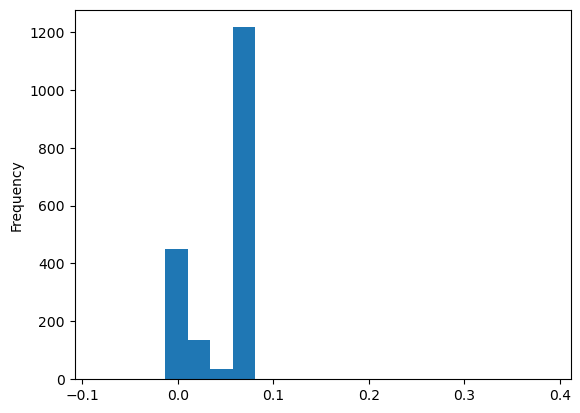

In [300]:
environmental_costs_std_mean['z'].plot.hist(bins=20)

0


### 6.4. Impose chance constraint formulation

Data manipulation:
- manipulate the environmental cost by adding the product of the PDF of the probability level and the standard deviation of the environmental costs
- exchange the updated enviornmental costs in the environmental cost matrix

In [216]:
lambda_QB = 0.9
ppf_lambda_QB = scipy.stats.norm.ppf(lambda_QB)
environmental_cost_updated = {}
for process_id, environmental_cost in environmental_costs_std.items():
    pulpo_worker.instance.ENV_COST_MATRIX[(process_id, method)] = environmental_cost_mean[process_id] + ppf_lambda_QB * environmental_costs_std[process_id]

#### 6.4.1. Solve the chance constrained problem

In [217]:
pulpo_worker.solve()

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Cols:       39128 lower bounds exceeding       -1e+20 are treated as -Infinity
Cols:       39128 upper bounds exceeding        1e+20 are treated as +Infinity
Rows:       19561 lower bounds exceeding       -1e+20 are treated as -Infinity
Rows:       19562 upper bounds exceeding        1e+20 are treated as +Infinity


In [ ]:
result_data = extract_results(pulpo_worker.instance, pulpo_worker.project, pulpo_worker.database, choices, {}, demand,
                            pulpo_worker.lci_data['process_map'], pulpo_worker.lci_data['process_map_metadata'],
                            pulpo_worker.lci_data['intervention_map'], pulpo_worker.lci_data['intervention_map_metadata'],
                            pulpo_worker.directory, "")

- Copmute the standard deviation and mean of the environmental cost flows
- Look into how the L2 and L1 norm differ for the impact calculation

### 6.5. Solve the CC problem for a set of probability levels

In [ ]:
result_data_CC = {}
lambda_array = np.linspace(0.5,1, 5, endpoint=False)
for lambda_QB in lambda_array:
    print(f'solving CC problem for lambda_QB = {lambda_QB}')
    ppf_lambda_QB = scipy.stats.norm.ppf(lambda_QB)
    environmental_cost_updated = {(process_id, method): environmental_cost_mean[process_id] + ppf_lambda_QB * environmental_costs_std[process_id] for process_id in environmental_costs_std.keys()}
    pulpo_worker.instance.ENV_COST_MATRIX.store_values(environmental_cost_updated, check=True)
    # for process_id, environmental_cost in environmental_costs_std.items():
    #     updated_environmental_cost = environmental_cost_mean[process_id] + ppf_lambda_QB * environmental_costs_std[process_id]
    #     pulpo_worker.instance.ENV_COST_MATRIX[(process_id, method)].set_value(updated_environmental_cost)
    pulpo_worker.solve()

    result_data_CC[lambda_QB] = extract_results(pulpo_worker.instance, pulpo_worker.project, pulpo_worker.database, choices, {}, demand,
                                pulpo_worker.lci_data['process_map'], pulpo_worker.lci_data['process_map_metadata'],
                                pulpo_worker.lci_data['intervention_map'], pulpo_worker.lci_data['intervention_map_metadata'],
                                pulpo_worker.directory, "")
    

Creating Instance
Instance created
solving CC problem for lambda_QB = 0.5
Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Cols:       39128 lower bounds exceeding       -1e+20 are treated as -Infinity
Cols:       39128 upper bounds exceeding        1e+20 are treated as +Infinity
Rows:       19561 lower bounds exceeding       -1e+20 are treated as -Infinity
Rows:       19562 upper bounds exceeding        1e+20 are treated as +Infinity
Creating Instance
Instance created
solving CC problem for lambda_QB = 0.6
Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Cols:       39128 lower bounds exceeding       -1e+20 are treated as -Infinity
Cols:       39128 upper bounds exceeding        1e+20 are treated as +Infinity
Rows:       19561 lower bounds exceeding       -1e+20 are treated as -Infinity
Rows:       19562 upper bounds exceeding        1e+20 are treated as +Infinity
Cr

#### 6.5.1. Look into how the probability levels influence the result

The total impact of the result:

In [390]:
def plot_CC_pareto_solution_bar_plots(data:pd.DataFrame, y_label:str):
    """
        args:
            data:       columns: lambdas, rows: QBs grouped by something
    """
    
    # set figure and plot
    width = 6
    height = 6
    _, ax = plt.subplots(1, 1, figsize=(width,height))

    data_cleaned = data.copy()
    data_cleaned[data.abs() < data.abs().sum()/50] = 0
    data_cleaned = data_cleaned.drop(index = data_cleaned.index[(data_cleaned == 0).all(axis=1)])
    data_cleaned_scaled = data_cleaned.abs().divide(data_cleaned.abs().sum())
    data_cumsum = data_cleaned_scaled.cumsum(axis=0)
    width = .8
    labels = ["{:.3f}".format(label) for label in data.columns.astype(float).values]
    bottom_data = np.zeros(len(labels))
    for i_row, (type, row_data) in enumerate(data_cumsum.iterrows()):
        ax.bar(labels, row_data.values-bottom_data, width, bottom=bottom_data, label=type, color=mpl.cm.tab20.colors[i_row])
        bottom_data = row_data.values
    ax.axhline(y=0, color='k')
    ax.set_xlabel("probability level ($\lambda$)")
    ax.set_ylabel("{} in [\%]".format(y_label))
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

In [387]:
impacts = {}
print(method)
for lambda_QB, result_data in result_data_CC.items():
    impacts[lambda_QB] = result_data['impacts'].set_index('Key').loc[method,'Value']
    print('{}: {}'.format(lambda_QB, impacts[lambda_QB]))


('IPCC 2013', 'climate change', 'GWP 100a')
0.5: 15998358670.367128
0.6: 16583975827.90842
0.7: 17210521485.59533
0.8: 17943783854.492004
0.9: 18960692070.528236


The changs in the choices of the optimizer

In [253]:
# [result_data['choices'].rename({varname: f'{lambda_QB} - {varname}' for varname in result_data['choices'].columns.get_level_values(0)}, level=0, axis='columns') for lambda_QB, result_data in result_data_CC.items()]
choices_CC = pd.concat(
    [result_data_CC[list(result_data_CC.keys())[0]]['choices'][[('electricity', 'Process'), ('electricity', 'Capacity')]]] + 
    [result_data['choices'][('electricity', 'Value')].rename(f'{lambda_QB} - electricity', level=0) for lambda_QB, result_data in result_data_CC.items()]
    , axis=1
    )
choices_CC 

,"(electricity, Process)","(electricity, Capacity)",0.5 - electricity,0.6 - electricity,0.7 - electricity,0.8 - electricity,0.9 - electricity
Process 0,"electricity production, hard coal | electricit...",1.000000e+16,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00
Process 1,"electricity production, nuclear, pressure wate...",1.000000e+16,8.350729e+10,8.350729e+10,8.350729e+10,8.350729e+10,8.350729e+10
Process 2,"electricity production, wind, 1-3MW turbine, o...",1.000000e+16,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00
Process 3,"electricity production, lignite | electricity,...",1.000000e+16,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00


Changes in the scaling vector and the characterized and scaled inventories

In [389]:
for lambda_1, lambda_2 in zip(lambda_array[:len(lambda_array)-1], lambda_array[1:len(lambda_array)]):
    print(f'lambda_1: {lambda_1}\nlambda_2: {lambda_2}\n')
    scaling_vector_diff = ((result_data_CC[lambda_1]['scaling_vector']['Value'] - result_data_CC[lambda_2]['scaling_vector']['Value']))
    scaling_vector_ratio = (scaling_vector_diff / result_data_CC[lambda_1]['scaling_vector']['Value']).abs().sort_values(ascending=False)
    characterized_scaling_vector_diff = (scaling_vector_diff * pd.Series(environmental_cost_mean).reindex(scaling_vector_diff.index))
    characterized_scaling_vector_diff_relative = (characterized_scaling_vector_diff / result_data_CC[lambda_1]['impacts'].set_index('Key').loc[method, 'Value']).abs().sort_values(ascending=False)

    print('Amount of process scaling variables that changed:\n{}: >1% \n{}: >10%\n{}: >100%\n{}: >1000%\n'.format((scaling_vector_ratio > 0.01).sum(), (scaling_vector_ratio > 0.1).sum(), (scaling_vector_ratio > 1).sum(), (scaling_vector_ratio > 10).sum()))
    print('Amount of process characterized scaling variables (impacts per process) that changed:\n{}: >1% \n{}: >10%\n{}: >100%\n{}: >1000%\n'.format((characterized_scaling_vector_diff_relative > 0.01).sum(), (characterized_scaling_vector_diff_relative > 0.1).sum(), (characterized_scaling_vector_diff_relative > 1).sum(), (characterized_scaling_vector_diff_relative > 10).sum()))
    print('{:.5e}: is the maximum impact change in one process\n{:.5e}: is the total impact change\n'.format(characterized_scaling_vector_diff_relative.max(), characterized_scaling_vector_diff_relative.sum()))

    amount_of_rows_for_visiualization = 10
    print('The relative change of the scaling vector (s_lambda_1 - s_lambda_2)/s_lambda_1:\n')
    print(scaling_vector_ratio.iloc[:amount_of_rows_for_visiualization].rename(result_data_CC[lambda_2]['scaling_vector']['Process metadata']).sort_values(ascending=False))
    print('\n---\n')
    print('The relative change of the characterized scaling vector (s_lambda_1 - s_lambda_2)*QB_s / QBs:\n')
    print(characterized_scaling_vector_diff_relative.iloc[:amount_of_rows_for_visiualization].rename(result_data_CC[lambda_2]['scaling_vector']['Process metadata']))
    print('\n---\n')

lambda_1: 0.5
lambda_2: 0.6

Amount of process scaling variables that changed:
89: >1% 
53: >10%
30: >100%
24: >1000%

Amount of process characterized scaling variables (impacts per process) that changed:
0: >1% 
0: >10%
0: >100%
0: >1000%

7.63163e-12: is the maximum impact change in one process
4.01645e-11: is the total impact change

The relative change of the scaling vector (s_lambda_1 - s_lambda_2)/s_lambda_1:

treatment of used purse seiner, wood | used purse seiner, wood | RLA                                                                   inf
treatment of used purse seiner, wood | used purse seiner, wood | RoW                                                                   inf
ethanol production from wood | ethanol, without water, in 95% solution state, from fermentation | CH                                   inf
market for used purse seiner, wood | used purse seiner, wood | GLO                                                                     inf
operation, housing syste

In [402]:
amount_of_processes_in_diagram = 10
data_QBs_list = []
for lambda_1 in lambda_array:
    QBs = result_data_CC[lambda_1]['scaling_vector']['Value'] * pd.Series(environmental_cost_mean).reindex(result_data_CC[lambda_1]['scaling_vector']['Value'].index)
    data_QBs_list.append(QBs.sort_values(ascending=False).iloc[:amount_of_processes_in_diagram])
    print(QBs.sort_values(ascending=False).iloc[:amount_of_processes_in_diagram].sum()/QBs.sum())
data_QBs = pd.concat(data_QBs_list, axis=1)
data_QBs.columns = lambda_array.astype(str)

0.7512865639842483
0.7512865640019921
0.7512865640019921
0.7512865639997521
0.7512865640001211


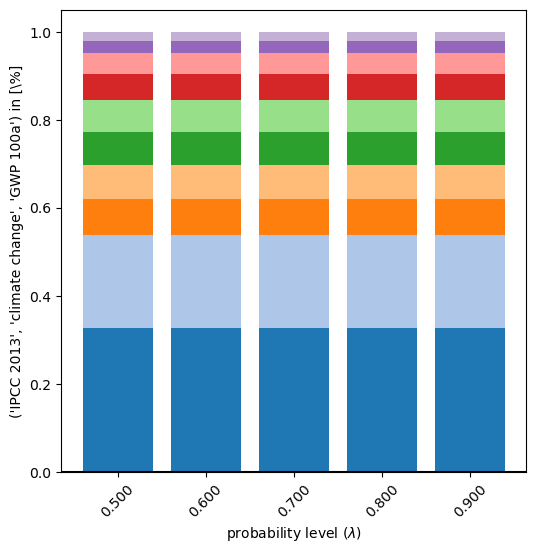

In [399]:
plot_CC_pareto_solution_bar_plots(data_QBs, method)

TO DO:
- Extract environmental costs from pyomo